In [39]:
## Chapter 8 Lab: Tree-Based Methods

# Previously seen imports
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

# New imports
from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text)
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
from ISLP.bart import BART

In [40]:
## Fitting Classification Trees

# We use carseats data set
# Sales is a continuous var, so we use numpy's where() function to create
# a variable called High with two levels
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8, "Yes", "No")


In [41]:
# Fit a classification tree to predict High using all the other variables
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [42]:
# param min_samples_split = min # of obs. in a node to be eligible for splitting
# param criterion = entropy or Gini as split criterion
clf = DTC(criterion='entropy', max_depth=3, random_state=0)
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [43]:
# Let's see how the model performs
accuracy_score(High, clf.predict(X))

0.79

In [44]:
# We can use log_loss to access the deviance
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev
# a small deviance indicates a tree that provides a good fit to the training data

0.4710647062649358

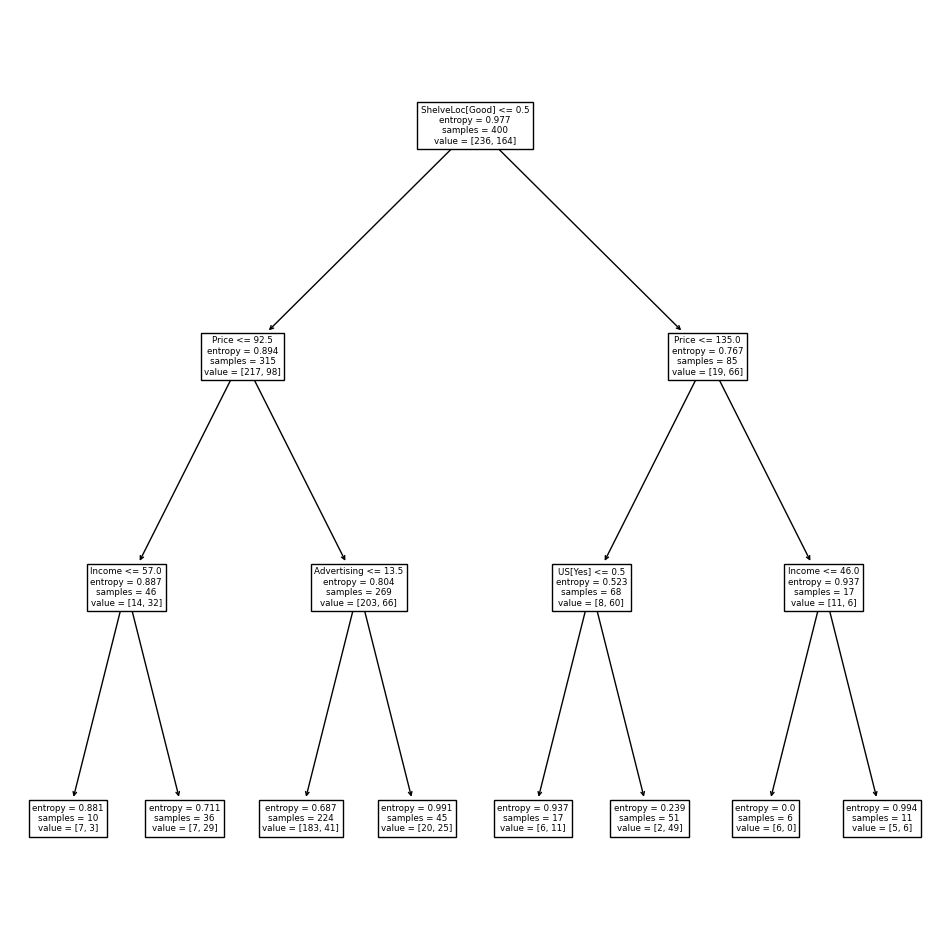

In [45]:
# We can graphically display the tree
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,feature_names=feature_names,ax=ax);

In [46]:
# We see evidence to support the claim that ShelveLoc is the most
# important indicator of Sales

# We also can use export_text() to see a text representation of the tree
print(export_text(clf, feature_names=feature_names, show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In [47]:
# Let's see the performance on the test set:

validation = skm.ShuffleSplit(n_splits=1, test_size=200, random_state=0)
results = skm.cross_validate(clf, D, High, cv=validation)
results['test_score']

array([0.685])

In [48]:
# Use CV to prune the tree on the training set

(X_train, X_test, High_train, High_test) = skm.train_test_split(X, High, test_size=0.5, random_state=0)

# refit the full tree on training set (no max_depth param b/c will find using CV later)
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.735

In [49]:
# cost complexity pruning

ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10, random_state=1, shuffle=True)

In [50]:
grid = skm.GridSearchCV(clf, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_

0.685

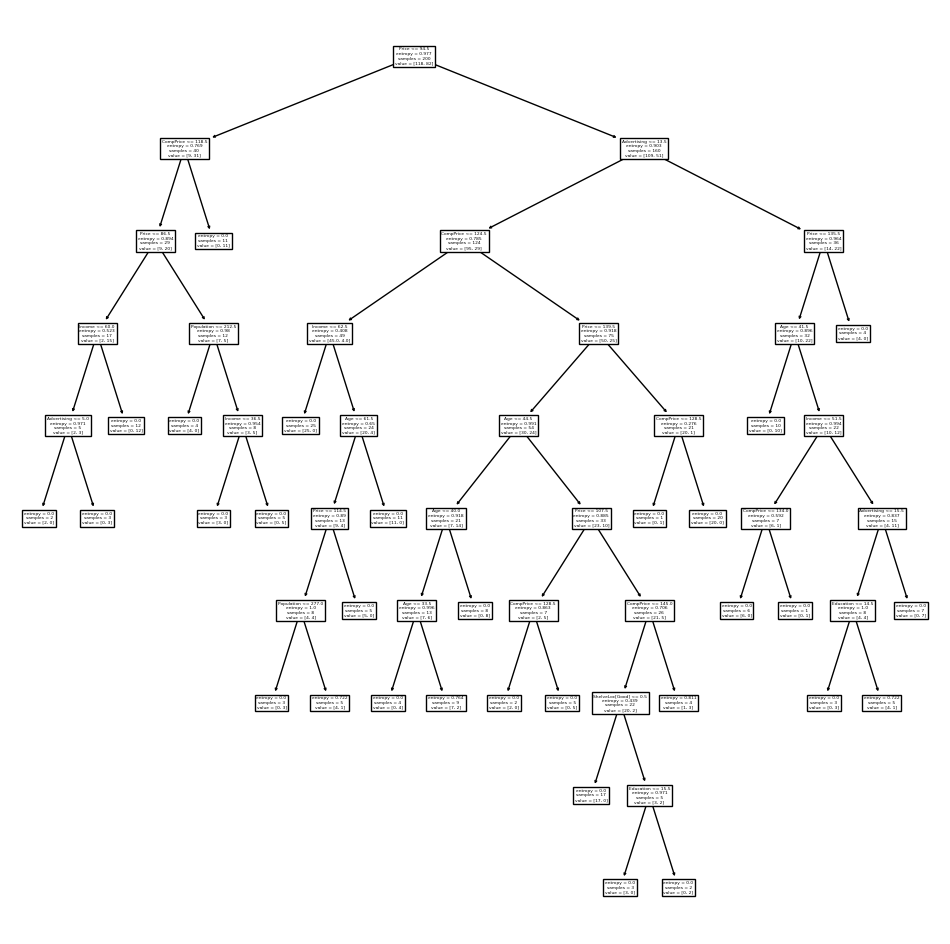

In [51]:
# Visually examine the pruned tree:

ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_, feature_names=feature_names, ax=ax);

In [52]:
# How many leaves?

best_.tree_.n_leaves

30

In [53]:
# Pruned tree performance on test set:


print(accuracy_score(High_test, best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test), High_test)
confusion

# We see that the accuracy on the test set has improved to 72%

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


In [54]:
## Fitting Regression Trees

# We will use the Boston dataset; steps are similar as those for classification trees

Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [55]:
# 70-30 split of data into training and testing sets
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, Boston['medv'], test_size=0.3, random_state=0)

[Text(0.5, 0.875, 'rm <= 6.797\nsquared_error = 84.765\nsamples = 354\nvalue = 22.745'),
 Text(0.25, 0.625, 'lstat <= 14.405\nsquared_error = 35.011\nsamples = 284\nvalue = 19.614'),
 Text(0.125, 0.375, 'dis <= 1.474\nsquared_error = 20.776\nsamples = 167\nvalue = 22.981'),
 Text(0.0625, 0.125, 'squared_error = 0.0\nsamples = 2\nvalue = 50.0'),
 Text(0.1875, 0.125, 'squared_error = 12.072\nsamples = 165\nvalue = 22.653'),
 Text(0.375, 0.375, 'crim <= 5.782\nsquared_error = 16.049\nsamples = 117\nvalue = 14.808'),
 Text(0.3125, 0.125, 'squared_error = 10.345\nsamples = 67\nvalue = 16.872'),
 Text(0.4375, 0.125, 'squared_error = 10.334\nsamples = 50\nvalue = 12.042'),
 Text(0.75, 0.625, 'rm <= 7.435\nsquared_error = 85.388\nsamples = 70\nvalue = 35.451'),
 Text(0.625, 0.375, 'crim <= 7.393\nsquared_error = 44.147\nsamples = 47\nvalue = 30.921'),
 Text(0.5625, 0.125, 'squared_error = 19.597\nsamples = 43\nvalue = 32.465'),
 Text(0.6875, 0.125, 'squared_error = 6.997\nsamples = 4\nvalue = 

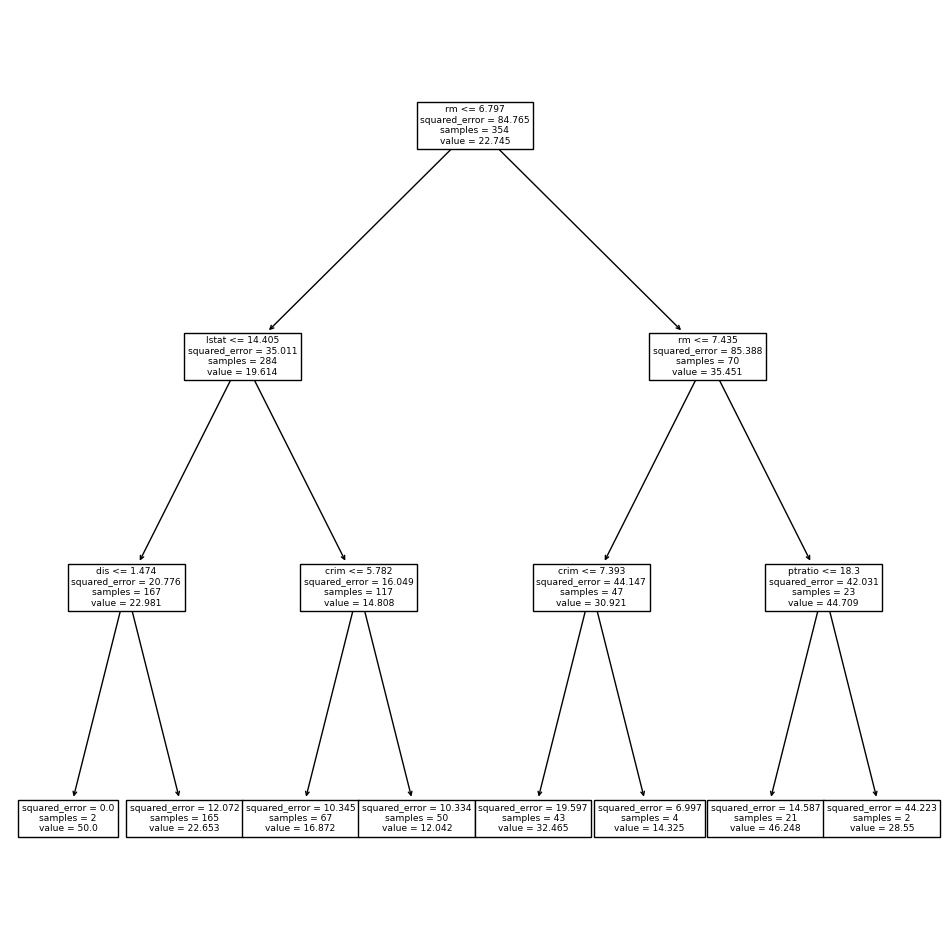

In [56]:
# fit regression tree
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg, feature_names=feature_names, ax=ax)

In [57]:
# Use CV to determine whether pruning the tree will improve performance

ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(reg, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [58]:
# Use the pruned tree chosen from CV to make predictions on test set
best_ = grid.best_estimator_

# Test set MSE
np.mean((y_test - best_.predict(X_test))**2)
# The square root of the test MSE is around 5.30, indicating that
# the model leads to test predictions that are within around 5400$
# of the true median home value for the suburb

28.06985754975404

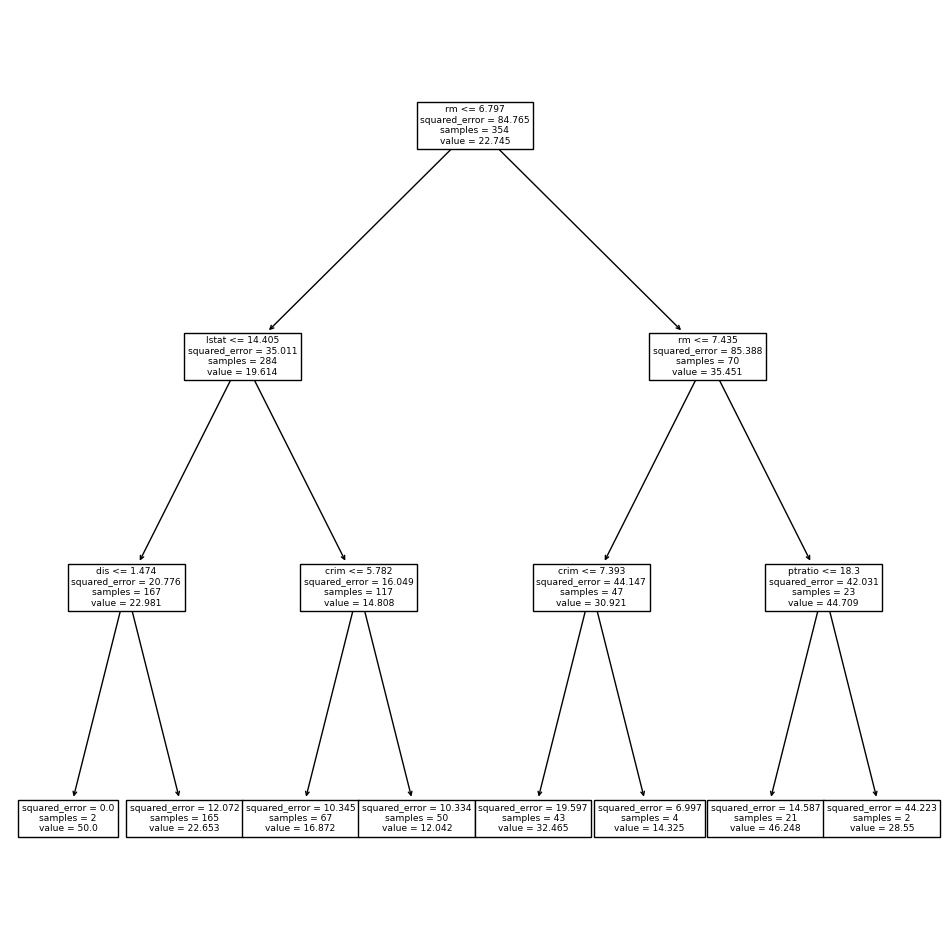

In [59]:
# Plotting the CV chosen tree will allow us to judge its interpretability
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_, feature_names=feature_names, ax=ax);

In [60]:
## Bagging and Random Forests

# Note: since bagging is simply a special case of random forests
# with m = p, we can use sklearn's RandomForestRegressor() for both
# bagging and random forests

# param max_features: determines number of predictors considered at each split
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

14.684333796052627

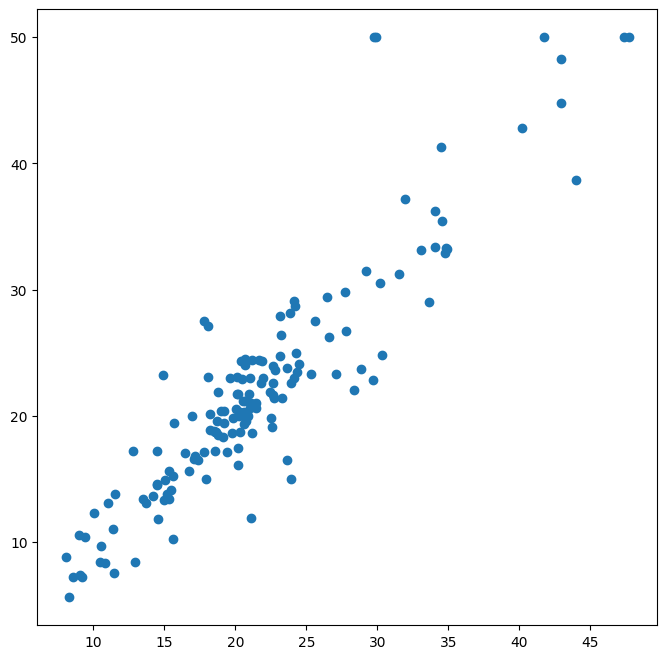

In [61]:
# Find the test MSE

ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

# We find that the test MSE offers significant improvement over
# fitting a single regression tree as we would expect

In [62]:
# Try changing the number of grown trees from the default of 100
# through the n_estimators argument
bag_boston = RF(max_features=X_train.shape[1], n_estimators=500, random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)
# We do not see much change
# (recall that bagging and random forests cannot overfit, but can underfit)

14.565312103157904

In [63]:
# Fit a random forest using the max_features argument
RF_boston = RF(max_features=6, random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)
# We observe that for this dataset, bagging outperformed the random forest

19.998839111842113

In [64]:
# View variable importance in the random forest:
feature_imp = pd.DataFrame({'importance':RF_boston.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)
# relative measure of the total decrease in node impurity that results from splits over that variable
# averaged over all trees

,importance
lstat,0.353808
rm,0.334349
ptratio,0.069519
crim,0.056386
indus,0.053183
dis,0.043762
nox,0.033085
tax,0.025047
age,0.019238
rad,0.005169


In [65]:
## Boosting

# We will use sklearn's GradientBoostingRegressor()

boost_boston = GBR(n_estimators=5000, learning_rate=0.001, max_depth=3, random_state=0)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

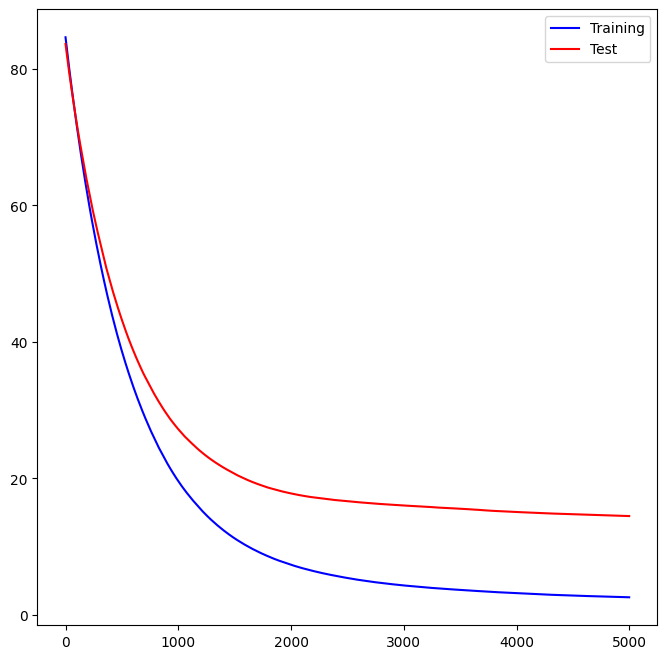

In [66]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx, boost_boston.train_score_, 'b', label='Training')
ax.plot(plot_idx, test_error, 'r', label='Test')
ax.legend();

In [67]:
# Find the test MSE
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

# We have a very similar test MSE as to bagging

14.478980532887332

In [68]:
# Can we improve performance by changing the learning rate?
boost_boston = GBR(n_estimators=5000, learning_rate=0.2, max_depth=3, random_state=0)
boost_boston.fit(X_train, y_train)
y_hat_boost = boost_boston.predict(X_test)
np.mean((y_test - y_hat_boost)**2)
# We see that increasing lambda from 0.001 to 0.2 leads to essentially the same test MSE

14.501514553719568

In [74]:
## Bayesian Additive Regression Trees

# We will use the ISLP.bart package

bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [ ]:
# Test MSE for BART
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

# We observe that the test MSE is quite similar to that of the random forest

22.145009458109225

In [80]:
# By seeing how many times each variable appeared in the collection of trees,
# we can obtain a measure of variable importance

var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0), index=D.columns)
var_inclusion

crim       26.933333
zn         27.866667
indus      26.466667
chas       22.466667
nox        26.600000
rm         29.800000
age        22.733333
dis        26.466667
rad        23.666667
tax        24.133333
ptratio    24.266667
lstat      31.000000
dtype: float64